# ISSR Prediction Models

## Imports

In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot
from imblearn.under_sampling import RandomUnderSampler
import keras_tuner as kt

## Load Dataset

In [2]:
data = pd.read_csv("C:/Users/jstej/anaconda3/George Mason DAEN MS/DAEN 690/Buffalo_issr2021.csv")

In [3]:
data.head()

,index,id_,year,month,day,hour,reltime,numlev,p_src,np_src,...,temp_f,temp_k,press_alt,rh_ice,issc,day_of_year,volume,floor,ceiling,vertical_depth
0,0,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,...,33.62,274.05,353.44,0.727,no,1-1,0.25,0.0,0.0,0.0
1,1,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,...,33.62,274.05,363.64,0.727,no,1-1,0.25,0.0,0.0,0.0
2,2,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,...,32.00,273.15,763.30,0.740,no,1-1,0.25,0.0,0.0,0.0
3,3,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,...,28.76,271.35,1507.31,0.737,no,1-1,0.25,0.0,0.0,0.0
4,4,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,...,24.08,268.75,2498.86,0.859,no,1-1,0.25,0.0,0.0,0.0


## Filter to 2022 and 2023

In [4]:
df = data[(data['year'] >= 2022) & (data['year'] <= 2023) & (data['press'] != -9999)]

## Preprocessing

### Convert issc from characters to integers

In [5]:
warnings.filterwarnings("ignore")
df['issc'] = df['issc'].replace({'yes': 1, 'no': 0})

In [6]:
df

,index,id_,year,month,day,hour,reltime,numlev,p_src,np_src,...,temp_f,temp_k,press_alt,rh_ice,issc,day_of_year,volume,floor,ceiling,vertical_depth
110284,110284,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,...,40.28,277.75,786.48,0.908,0,1-1,0.250000,0.0,0.0,0.0
110285,110285,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,...,40.46,277.85,1168.85,0.882,0,1-1,0.250000,0.0,0.0,0.0
110286,110286,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,...,41.36,278.35,1332.83,0.781,0,1-1,0.250000,0.0,0.0,0.0
110287,110287,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,...,41.54,278.45,1372.03,0.784,0,1-1,0.250000,0.0,0.0,0.0
110288,110288,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,...,37.94,276.45,2135.52,0.952,0,1-1,0.250000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332167,332167,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,...,-59.44,222.35,40837.02,0.023,0,12-31,0.333333,0.0,0.0,0.0
332168,332168,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,...,-61.78,221.05,41838.00,0.025,0,12-31,0.333333,0.0,0.0,0.0
332169,332169,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,...,-63.22,220.25,42393.97,0.026,0,12-31,0.333333,0.0,0.0,0.0
332170,332170,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,...,-63.22,220.25,42417.66,0.026,0,12-31,0.333333,0.0,0.0,0.0


### Creating X and Y variables

In [7]:
X = df[['month', 'day', 'hour', 'etime', 'press', 'temp_f', 'press_alt', 'rh_ice', 'dpdp', 'volume', 'vertical_depth']]
y = df['issc']

### Undersample as there is an imbalance in yes and no for issc

In [8]:
rus = RandomUnderSampler(random_state=42)

In [9]:
X_resampled, y_resampled = rus.fit_resample(X, y)

### Split the dataset into train and test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

In [11]:
scaler = StandardScaler()
X_trained_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fit to logistic regression model

In [12]:
model = LogisticRegression()
model.fit(X_trained_scaled, y_train)

LogisticRegression()

In [13]:
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9935897435897436


In [14]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[77,  1],
       [ 0, 78]], dtype=int64)

In [15]:
data = pd.concat([X, y], axis = 1)

<AxesSubplot:>

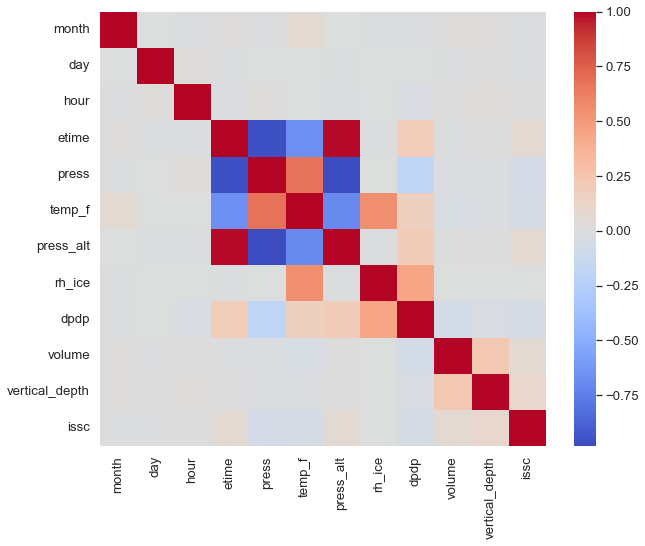

In [16]:
# Plot correlation matrix as heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2) 

sns.heatmap(data.corr(), fmt='.2f', cmap='coolwarm')

## Time Series Modeling

In [17]:
#Create DataFrame with volume column. Volume is based off of the number of times per day that an issc was yes
df['date'] = pd.to_datetime(df['date'])
issc_counts_per_day = df[df['issc'] == 1].groupby(df['date'].dt.date).size()
all_dates = pd.DataFrame(index=pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D'))
issc_counts_per_day.name = 'volume'
new_df = all_dates.join(issc_counts_per_day, how='left').fillna(0)

In [18]:
# Add the day's average temperature 
temp_f_per_day = df.groupby(df['date'].dt.date)['temp_f'].mean()

temp_f_per_day.name = 'temp_f'

new_df = new_df.join(temp_f_per_day, how = 'left').fillna(0)

In [19]:
# Add the day's average realitive humidity to ice
rh_ice_per_day = df.groupby(df['date'].dt.date)['rh_ice'].mean()

rh_ice_per_day.name = 'rh_ice'

new_df = new_df.join(rh_ice_per_day, how = 'left').fillna(0)

In [20]:
new_df

,volume,temp_f,rh_ice
2022-01-01,0.0,-12.269579,0.578795
2022-01-02,1.0,-14.756154,0.699731
2022-01-03,0.0,-13.327016,0.339194
2022-01-04,0.0,-21.170391,0.386648
2022-01-05,0.0,-18.562188,0.479109
...,...,...,...
2023-12-27,1.0,-16.036244,0.612503
2023-12-28,0.0,-10.276522,0.513571
2023-12-29,0.0,-14.245176,0.477294
2023-12-30,3.0,-15.195854,0.484610


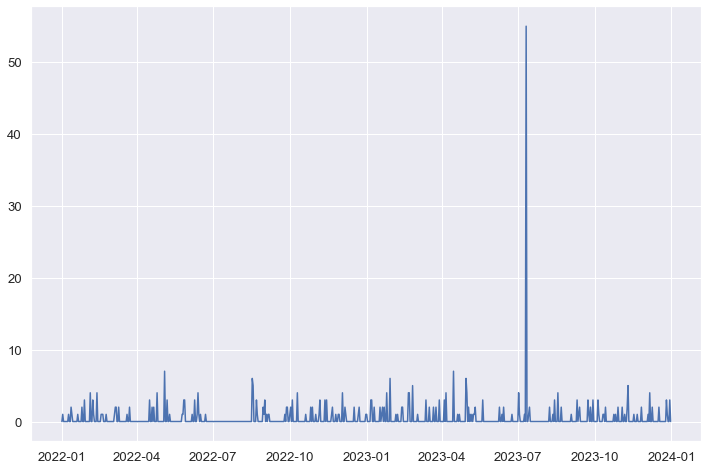

In [21]:
plt.figure(figsize = (12, 8))
plt.plot(new_df['volume'])

Analysis: There is a large outlier on July 11, 2023. This needs to be removed to output a more accurate time series model. 

### Autoregressive Integrated Moving Average (ARIMA) Model

In [22]:
new_df.drop('2023-07-11', inplace = True)

In [23]:
#Source: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
#Source: https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp
#ARIMA is statistical analysis model that uses time series data to predict future trends. This model can predict
#future values based on past values. ARIMA parameters include:
#p: the number of lag observations in the model
#d: the number of times the raw observations are differenced
#q: the size of the moving average window
#The ARIMA model identifies the appropriate number of lags.

#Splitting Training and Testing set
train_size = int(0.8 * len(new_df))
train, test = new_df.iloc[:train_size], new_df.iloc[train_size:]

# Fit ARIMA model
#Order represents, p, d, q. 
model = ARIMA(train['volume'], order=(3,1,3))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))

In [24]:
#Root Mean Squared Error is used to evaluate the model. RMSE takes the square root fo the average of the squared
#differences between the predicted values and the actual values.The lower the RMSE, the more accurate the model.
mse = mean_squared_error(test['volume'], predictions)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.9908482812343645


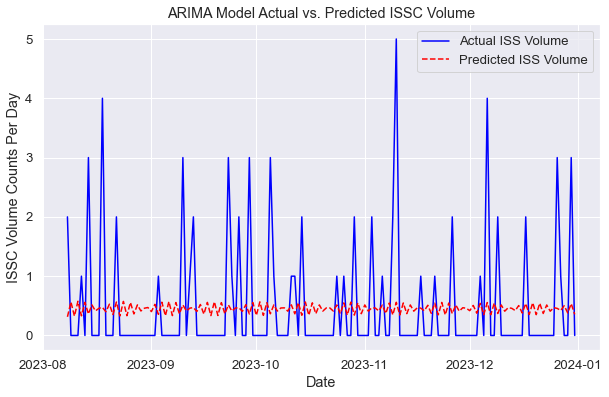

In [25]:
#Plotting Predicted versus Actual ISSC Volume Per Day
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['volume'], label='Actual ISS Volume', color='blue')
plt.plot(test.index, predictions, label='Predicted ISS Volume', color='red', linestyle='--')
plt.title('ARIMA Model Actual vs. Predicted ISSC Volume')
plt.xlabel('Date')
plt.ylabel('ISSC Volume Counts Per Day')
plt.legend()
plt.grid(True)
plt.show()

Analysis: First attempt at ARIMA did not yield great results. Need to try different parameters.

### ARIMA Parameter Tuning

In [26]:
#Assign ARIMA Paramters
#Source: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
#Source: https://levelup.gitconnected.com/simple-forecasting-with-auto-arima-python-a3f651271965
p_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
d_values = range(0,3)
q_values = range(0,3)

In [27]:
#Function that evaluates the ARIMA Model

def eval_arima_model(train, test, p_values, d_values, q_values):
    #Save best mse score, best parameters, and predictions made
    best_score, best_param, predict = float("inf"), None, float("inf")
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(train['volume'], order=(p, d, q))
                    model_fit = model.fit()
                    # Make predictions
                    predictions = model_fit.forecast(steps=len(test))
                    mse = (mean_squared_error(test['volume'], predictions))
                    print("The parameters p:", p, ", d:", d, ", q:", q, ". MSE =", mse)
                    #If mse is lower than the current best mse score, add that as the new mse
                    if mse < best_score:
                        best_score, best_param, predict = mse, order, predictions
                except:
                    continue
    print("Best ARIMA MSE Score =", best_score, best_param)
    
    #Plotting Predicted versus Actual ISSC Volume Per Day
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['volume'], label='Actual ISS Volume', color='blue')
    plt.plot(test.index, predict, label='Predicted ISS Volume', color='red', linestyle='--')
    plt.title('ARIMA Model Actual vs. Predicted ISSC Volume')
    plt.xlabel('Date')
    plt.ylabel('ISSC Volume Counts Per Day')
    plt.legend()
    plt.grid(True)
    plt.show()

The parameters p: 0 , d: 0 , q: 0 . MSE = 0.9901070856923484
The parameters p: 0 , d: 0 , q: 1 . MSE = 0.990641913553297
The parameters p: 0 , d: 0 , q: 2 . MSE = 0.9902975906242228
The parameters p: 0 , d: 1 , q: 0 . MSE = 1.2191780821917808
The parameters p: 0 , d: 1 , q: 1 . MSE = 0.9901069184602669
The parameters p: 0 , d: 1 , q: 2 . MSE = 0.9906574746910954
The parameters p: 0 , d: 2 , q: 0 . MSE = 1.2191780821917808
The parameters p: 0 , d: 2 , q: 1 . MSE = 1.219234441129646
The parameters p: 0 , d: 2 , q: 2 . MSE = 2.1870294861914474
The parameters p: 1 , d: 0 , q: 0 . MSE = 0.9906009780174189
The parameters p: 1 , d: 0 , q: 1 . MSE = 0.9905553378261007
The parameters p: 1 , d: 0 , q: 2 . MSE = 0.9903062069684999
The parameters p: 1 , d: 1 , q: 0 . MSE = 1.2191780821917808
The parameters p: 1 , d: 1 , q: 1 . MSE = 0.9906185633562165
The parameters p: 1 , d: 1 , q: 2 . MSE = 0.9949000899553908
The parameters p: 1 , d: 2 , q: 0 . MSE = 1.2191780821917808
The parameters p: 1 , d: 2

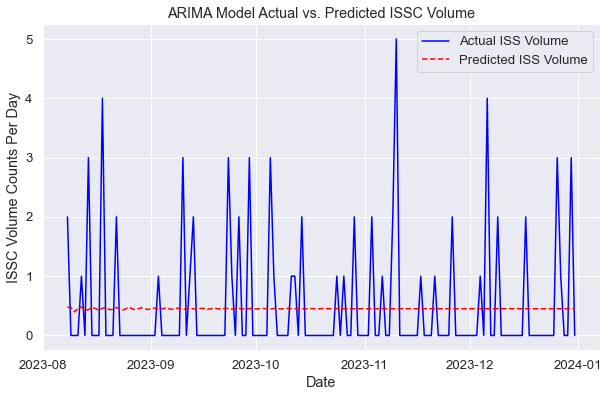

In [28]:
#Call function
eval_arima_model(train, test, p_values, d_values, q_values)

### Long Short Term Momory (LSTM)

In [29]:
#Source: https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/
#Source: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
#LSTM is an improvement of Reccurent Neural Networks. LSTM has a memory cell, which holds information for an extended period,
#which allows the model to learn long-term dependencies. 

#Input the number of lag features
num_lags = 2

#Create loop to add lag features to dataframe
for i in range(1, num_lags + 1):
    new_df[f'volume_lag{i}'] = new_df['volume'].shift(i)
    
# Fill missing values with 0
new_df['volume_lag1'] = new_df['volume_lag1'].fillna(0)
new_df['volume_lag2'] = new_df['volume_lag2'].fillna(0)

In [30]:
window_size = 5

new_df['rolling_avg'] = new_df['volume'].rolling(window = window_size).mean()
new_df['rolling_avg'] = new_df['rolling_avg'].fillna(0)

for i in range(1, num_lags + 1):
    new_df[f'rolling_avg_lag{i}'] = new_df['rolling_avg'].shift(i)
    
new_df['rolling_avg_lag1'] = new_df['rolling_avg_lag1'].fillna(0)
new_df['rolling_avg_lag2'] = new_df['rolling_avg_lag2'].fillna(0)

In [31]:
new_df['exp_smooth'] = new_df['volume'].ewm(span = window_size, adjust = False).mean()

for i in range(1, num_lags + 1):
    new_df[f'exp_smooth_lag{i}'] = new_df['exp_smooth'].shift(i)
    
new_df['exp_smooth_lag1'] = new_df['exp_smooth_lag1'].fillna(0)
new_df['exp_smooth_lag2'] = new_df['exp_smooth_lag2'].fillna(0)

In [32]:
new_df

,volume,temp_f,rh_ice,volume_lag1,volume_lag2,rolling_avg,rolling_avg_lag1,rolling_avg_lag2,exp_smooth,exp_smooth_lag1,exp_smooth_lag2
2022-01-01,0.0,-12.269579,0.578795,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2022-01-02,1.0,-14.756154,0.699731,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000
2022-01-03,0.0,-13.327016,0.339194,1.0,0.0,0.0,0.0,0.0,0.222222,0.333333,0.000000
2022-01-04,0.0,-21.170391,0.386648,0.0,1.0,0.0,0.0,0.0,0.148148,0.222222,0.333333
2022-01-05,0.0,-18.562188,0.479109,0.0,0.0,0.2,0.0,0.0,0.098765,0.148148,0.222222
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,1.0,-16.036244,0.612503,3.0,0.0,0.8,0.6,0.0,1.012312,1.018467,0.027701
2023-12-28,0.0,-10.276522,0.513571,1.0,3.0,0.8,0.8,0.6,0.674874,1.012312,1.018467
2023-12-29,0.0,-14.245176,0.477294,0.0,1.0,0.8,0.8,0.8,0.449916,0.674874,1.012312
2023-12-30,3.0,-15.195854,0.484610,0.0,0.0,1.4,0.8,0.8,1.299944,0.449916,0.674874


In [33]:
#Input x and y variables
X1 = new_df[['volume_lag1', 'volume_lag2', 'temp_f', 'rh_ice']].values
y1 = new_df['volume'].values

#scaler = StandardScaler()
#X1_scaled = scaler.fit_transform(X1)
#X1_reshape = X1_scaled.reshape((X1_scaled.shape[0], 1, X1_scaled.shape[1]))

#LSTM model
#Units = Dimensionality of the output space
#Activation = Activation Function, using relu, which is rectified linear unit
#Input_Shape: The shape of the input data that will be inputted into the LSTM
#Dense: A 1 in Dense specifies that there is only one desired output. 
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X1.shape[1], 1)),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')
#y1 = np.array(y1)

# Fit model. 
#Epoch is the amount fo times we pass the entire trainign set through the neural network
#Batch_size is the number of training samples per iteration
#Verbose displays information while the model runs
model.fit(X1, y1, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4853
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1864 
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3477 
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2389 
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0877 
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0617 
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0170 
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0697 
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1311 
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3232 
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1130 
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0054 
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2173 
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9595 
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


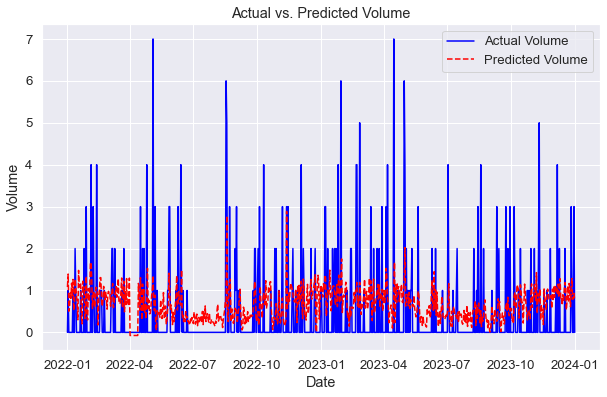

In [34]:
#Plotting actual vs. predicted issc volumes each day
actual_volume = new_df['volume']
predicted_volume = model.predict(X1)

# Plot actual vs. predicted volumes
plt.figure(figsize=(10, 6))
plt.plot(actual_volume.index, actual_volume, label='Actual Volume', color='blue')
plt.plot(actual_volume.index, predicted_volume, label='Predicted Volume', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Actual vs. Predicted Volume')
plt.legend()
plt.grid(True)
plt.show()

### Predicting the volume of issc for the next calandar day

In [50]:
#Extrating the last two volume lag variables
latest_volume_lag1 = new_df[['volume_lag1', 'volume_lag2', 'temp_f', 'rh_ice']].iloc[-1]

# Reshape the input data
#Convert into an array
X_pred = np.array([latest_volume_lag1])
#Reshape the X_pred into the proper format for LSTM which is number of samples, number of timesteps, and number of features
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1], 1)

# Make prediction
predicted_volume = model.predict(X_pred)

#Get the last date
latest_date = new_df.index[-1].date()

#Calculate the day we are predicitng for
next_date = latest_date + pd.DateOffset(days= 1)

#Outputting prediction
print(f"Predicted volume for {next_date}:", predicted_volume[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted volume for 2024-01-01 00:00:00: 0.39733472


Analysis: In this preliminary LSTM model, we are recieiving a high loss rate (difference between predicted and actual values) of 5.1436. This is likely due to an outlier in the data, which is skewing the loss rate.

### LSTM with Removing Outlier

As shown in the last chart, there is an outlier in the data, which is causing the high loss rate. We will try again after removing the outlier from the dataset. 

In [37]:
#Removing outlier
outlier_df = new_df[new_df.index != '2023-07-11']

In [38]:
outlier_df

,volume,temp_f,rh_ice,volume_lag1,volume_lag2,rolling_avg,rolling_avg_lag1,rolling_avg_lag2,exp_smooth,exp_smooth_lag1,exp_smooth_lag2
2022-01-01,0.0,-12.269579,0.578795,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2022-01-02,1.0,-14.756154,0.699731,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000
2022-01-03,0.0,-13.327016,0.339194,1.0,0.0,0.0,0.0,0.0,0.222222,0.333333,0.000000
2022-01-04,0.0,-21.170391,0.386648,0.0,1.0,0.0,0.0,0.0,0.148148,0.222222,0.333333
2022-01-05,0.0,-18.562188,0.479109,0.0,0.0,0.2,0.0,0.0,0.098765,0.148148,0.222222
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,1.0,-16.036244,0.612503,3.0,0.0,0.8,0.6,0.0,1.012312,1.018467,0.027701
2023-12-28,0.0,-10.276522,0.513571,1.0,3.0,0.8,0.8,0.6,0.674874,1.012312,1.018467
2023-12-29,0.0,-14.245176,0.477294,0.0,1.0,0.8,0.8,0.8,0.449916,0.674874,1.012312
2023-12-30,3.0,-15.195854,0.484610,0.0,0.0,1.4,0.8,0.8,1.299944,0.449916,0.674874


In [39]:
#Fitting model
X2 = outlier_df[['volume_lag1', 'volume_lag2', 'temp_f', 'rh_ice']].values
y2 = outlier_df['volume'].values

model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X2.shape[1], 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.fit(X2, y2, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2434   
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1414 
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9975 
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1731 
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0627 
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0109 
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0859 
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2112 
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2096 
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2443 
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0645 
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9022 
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9940 
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1904 
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

### LSTM Remove Outlier and Create Train and Test sets

In [40]:
#This is where we incorporate train and test to validate how well the model is performing. 
# Split the data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Fit model on training data
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate model on testing data
loss = model.evaluate(X_test, y_test)
print('Testing Loss:', loss)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2281
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9901 
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0723
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9948 
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1322 
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8679 
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0992
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9449 
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8940 
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1102
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1402
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9839
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0807
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0239
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9970
Epoch 16/50
1

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


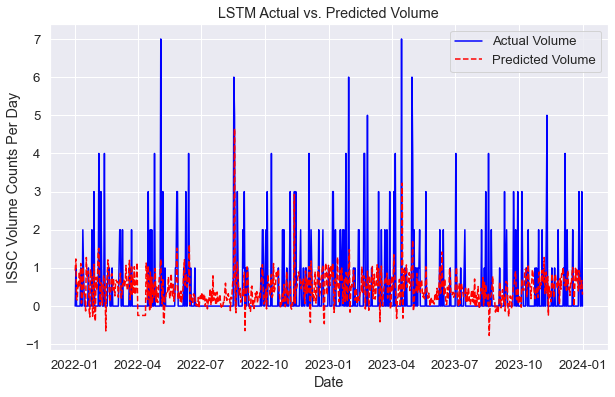

In [41]:
#Plotting actual vs. predicted issc volumes each day
actual_volume = outlier_df['volume']
predicted_volume = model.predict(X2)

# Plot actual vs. predicted volumes
plt.figure(figsize=(10, 6))
plt.plot(actual_volume.index, actual_volume, label='Actual Volume', color='blue')
plt.plot(actual_volume.index, predicted_volume, label='Predicted Volume', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('ISSC Volume Counts Per Day')
plt.title('LSTM Actual vs. Predicted Volume')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
#trying to find optimal hyper parameters for LSTM model

from tensorflow.keras.optimizers import Adam

# Define the grid of hyperparameters to search
units = [50, 100, 150]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64]

# Placeholder for storing the results
search_results = []

def build_and_evaluate_model(units, learning_rate, batch_size):
    # Build the model
    model = Sequential([
        LSTM(units=units, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=0, validation_split=0.2)
    
    # Evaluate the model
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse

# Iterate over each combination of hyperparameters
for u in units:
    for lr in learning_rates:
        for bs in batch_sizes:
            mse = build_and_evaluate_model(u, lr, bs)
            search_results.append((u, lr, bs, mse))
            print(f"Units: {u}, Learning Rate: {lr}, Batch Size: {bs}, MSE: {mse}")

# Find the best hyperparameters
best_hyperparams = min(search_results, key=lambda x: x[3])
print(f"Best Hyperparameters: Units={best_hyperparams[0]}, Learning Rate={best_hyperparams[1]}, Batch Size={best_hyperparams[2]} with MSE={best_hyperparams[3]}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 16, MSE: 0.6794116389823716
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000029C2DBB68B0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 32, MSE: 0.6430982118038059
5/5 ━━━━━━━━━━━

In [46]:
# Model with optimal parameters from cell above
model = Sequential([
    LSTM(units = 50, activation = 'relu', input_shape = (X_train.shape[1], 1)),
    Dense(1)
])

model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'mse')

model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_split = 0.2, verbose = 1)

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.1772 - val_loss: 1.0659
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1841 - val_loss: 1.1034
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0330 - val_loss: 1.0856
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1532 - val_loss: 1.0720
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3685 - val_loss: 1.0607
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2508 - val_loss: 1.0532
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2553 - val_loss: 1.0515
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1753 - val_loss: 1.0689
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2668 - val_loss: 1.0401
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1124 - val_loss: 1.0604
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2205 - val_loss: 1.0267
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1685 - val_l

### Predicting the volume of issc for the next calandar day

In [51]:
latest_volume_lag12 = outlier_df[['volume_lag1', 'volume_lag2', 'temp_f', 'rh_ice']].iloc[-1]
# Reshape the input data
X_pred = np.array([latest_volume_lag12])
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1], 1)

# Make predictions
predicted_volume = model.predict(X_pred)

#Get the last date
latest_date = new_df.index[-1].date()

#Calculate the day we are predicitng for
next_date = latest_date + pd.DateOffset(days= 1)

print(f"Predicted volume for {next_date}:", predicted_volume[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted volume for 2024-01-01 00:00:00: 0.39733472


Analysis: After removing the outlier, the LSTM model seems to perform better with bringing the training loss from 5.1436 to 1.2290. When analyzing the plot, appears to follow the actual volume decent, however, has trouble predicitng the extrme values. Although it may not guess if a day will have multiple instances of issc, it still might forecast the presence of at least 1. 

In [52]:
#Need to determine the optimal parameters and number of lag variables